# Les 04

## Inleiding

Dit is de werkcollege-oefening bij Les 04 van het vak *Advanced Datamining* (BFVH4DMN2). Bestudeer eerst de syllabus behorende bij deze les. Op BlackBoard kun je naast dit iPython/Jupyter notebook een tweetal Python-bestanden vinden. Sla deze op in dezelfde folder als dit notebook. Het verdient aanbeveling om voor elke les een aparte folder aan te maken.

- **template.py** bevat een opzet voor een module met object-georiënteerde implementaties van neurale netwerk algoritmen. Het doel van deze oefening is om deze code aan te vullen en uit te werken tot een correct werkend model. Open dit bestand in een code-editor naar keuze en sla het op als **model.py**. Vergeet niet om tijdens het uitwerken van deze oefening je aanpassingen in de editor telkens op te slaan voordat je de code in dit notebook uitvoert!

- **data.py** bevat een aantal functies die helpen bij het genereren en het visualiseren van de gebruikte datasets. Deze functies hoeven maar één keer ingelezen te worden en hoef je niet te wijzigen om deze opdracht correct uit te kunnen voeren.

Laten we dus beginnen om deze functies te importeren, samen met wat initialisatie-code: plaats de cursor in de cel hieronder en druk op Shift+Enter.

In [9]:
%matplotlib inline
from importlib import reload

import model, data

## Softmax

We gaan in dit werkcollege *multinomiale* classificatie implementeren. Dat wil zeggen dat de dataset meer dan twee klasselabels zal bevatten. De nieuwe dataset zal worden getrokken uit een zogenaamde [Newton fractal](https://en.wikipedia.org/wiki/Newton_fractal). De details doen er nu niet zoveel toe, maar een kenmerk hiervan is dat ze op elke grootte-schaal details bevat. Een eindige dataset kan die details nooit allemaal representeren, en een neuraal netwerk kan evenmin al die kenmerken fitten, maar het is interessant om te kijken hoe ver een model kan komen. Grafisch ziet de fractal die wij zullen gebruiken er als volgt uit.

[![Newton fractal](https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Julia_set_for_the_rational_function.png/240px-Julia_set_for_the_rational_function.png)](https://upload.wikimedia.org/wikipedia/commons/d/db/Julia_set_for_the_rational_function.png)

De data die wij zullen bekijken kent twee attributen en drie verschillende klassen. De attributen komen overeen met de $x$- en $y$-as van de figuur; de drie klassen zijn hier weergegeven in de kleuren blauw, rood en groen. Opmerkelijk aan deze fractal is dat op de grens tussen twee klassen altijd "eilandjes" liggen van de derde klasse. Maar op de grenzen met die eilandjes liggen ook weer kleinere eilandjes, *ad infinitum*. Eigenlijk grenzen de klassen niet paarsgewijs aan elkaar: elk grenspunt van een klasse grenst aan alle drie de klassen. Maar dat terzijde.

Gegeven is een functie `data.multinomial()` die een steekproef neemt van een bepaald aantal punten uit deze dataset. Er bestaan ook versies met meer dan drie klassen; een verplicht argument geeft daarom aan hoeveel klassen we willen kiezen. Standaard worden er 512 datapunten gegenereerd.

In [2]:
help(data.multinomial)

Help on function multinomial in module data:

multinomial(classes, num=512, seed=None)
    Generate a dataset based on Newton's method applied to 1+(-z)^c=0.
    
    Keyword arguments:
    classes  -- number of classes to generate
    num      -- number of instances (default 512)
    seed     -- a seed to initialise the random number generator (default random)
    
    Return values:
    xs       -- values of the attributes x1 and x2
    ys       -- class labels in one-hot encoding



Laten we beginnen een dataset met drie klassen te genereren. Elke instance heeft twee attributen $x_1$ en $x_2$; het klasselabel wordt gegeven in de vorm van een one-hot encoding en bestaat daarmee uit een lijst met drie waarden $y_1$, $y_2$ en $y_3$ die gelijk zijn aan 0 of 1. Wanneer we de data plotten met de `data.scatter()` functie worden er drie plotjes gemaakt, voor elke klasse één. Ga voor jezelf na dat deze overeenkomen met respectievelijk de blauwe, rode en groene klassen uit de afbeelding hierboven.

Eerste instance:
Attributen  x = [0.31045384030441703, -0.5609355447880365]
Klasselabel y = [0.0, 0.0, 1.0]


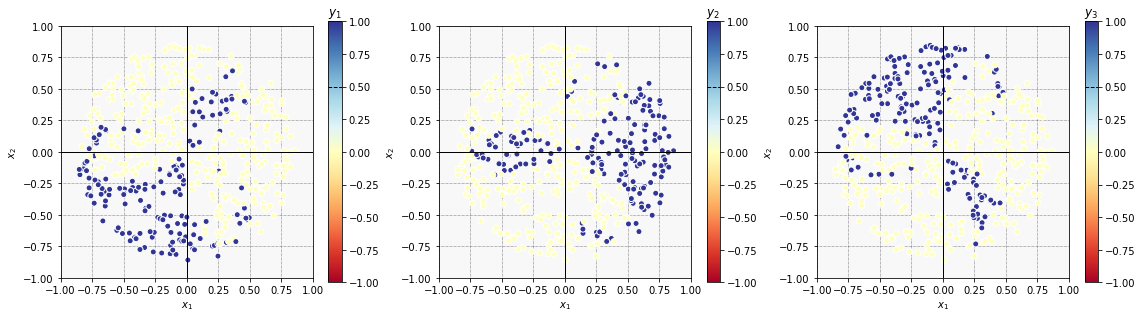

In [3]:
reload(data)
xs, ys = data.multinomial(3)
print('Eerste instance:')
print('Attributen  x =', xs[0])
print('Klasselabel y =', ys[0])
data.scatter(xs, ys)

We kunnen eens beginnen deze data te fitten met een multi-layer perceptron zoals we dat in de vorige les hebben geïmplementeerd. Neem de diverse activatie- en loss-functies samen met de code voor de classes `Layer()`, `FullLayer()` en `LossLayer()` over uit de vorige les. Als het goed is werkt het onderstaande model nu "out of the box".

De learning rate $\alpha$ is hier gelijk genomen aan `alpha=0.05`. De hidden layer bevat tien neuronen met een softsign-activatiefunctie. Dit zijn voor dit probleem redelijke waarden, maar voel je vrij deze aan te passen als jouw model geen bevredigende voorspellingen geeft. De breedte van de input layer dient wel op twee gesteld te worden en die van de output layer op drie. (Waarom?)

Als het goed is worden in elke grafiek de punten van één klasse geïdentificeerd (in blauw) ten opzichte van de andere (in geel). De voorspellingen van het model (de achtergrondkleur) dienen daar redelijkerwijs mee overeen te komen. Convergeert het model ogenschijnlijk naar een acceptabele oplossing?

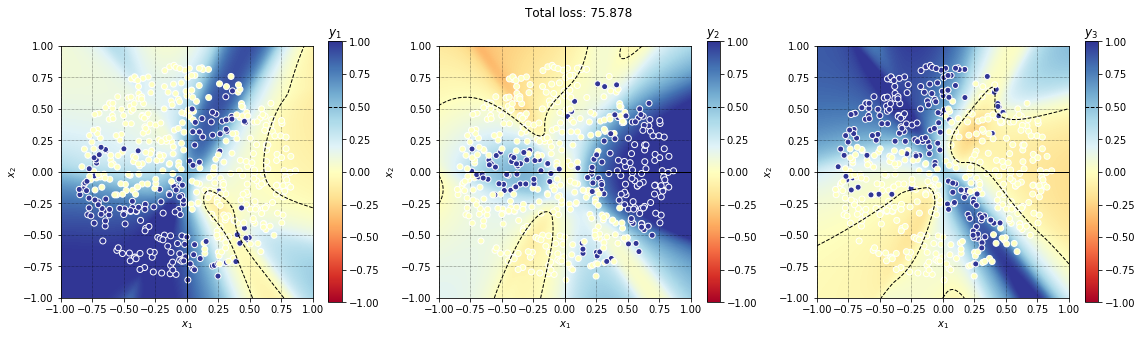

In [12]:
reload(model)

hidden = model.FullLayer(2, 10, act_func=model.softsign_act_func)
output = model.FullLayer(10, 3, act_func=model.identity_act_func)
loss = model.LossLayer(loss_func=model.quadratic_loss_func)
my_network = hidden + output + loss
my_network.fit(xs, ys, alpha=0.05)
data.scatter(xs, ys, model=my_network)

De uitkomsten van het model hierboven hebben een bereik van -1 (rood) tot +1 (blauw), of vallen daar zelfs nog buiten wanneer de kleuren worden geclipt. Hoewel de klasselabels gegeven zijn door middel van nullen en enen kan de uitvoer van het model dus *niet* gezien worden als een schatting van de kans op een zeker klasselabel. Immers, kansen kunnen nooit kleiner dan nul of groter dan één zijn. Dit is op te lossen met een *softmax* output layer. Het past niet zo goed in onze gekozen opzet om dit te implementeren in de vorm van een nieuwe activatie-functie. Daarom zullen we een geheel nieuwe child-class `SoftmaxLayer()` van `Layer()` aanmaken.

In het gegeven template worden de speciale `__init__()` en `__str__()` functies reeds gegeven; deze hoeven eigenlijk niet meer te worden aangepast. De softmax layer heeft geen parameters dus die hoeven ook niet te worden geïnitialiseerd of weergegeven. Wel zal de functie `predict()` moeten worden toegevoegd. Deze ontvangt een lijst met invoerwaarden $x_n$ waarop de softmax-functie dient te worden toegepast om te komen tot de te retourneren uitvoerwaarden $\hat{y}_n$ volgens

\begin{equation*}
\hat{y}_{n}=\frac{e^{x_{n}}}{\sum_{j}e^{x_{j}}}
\end{equation*}

Bereken dus eerst een nieuwe lijst met $e^{x_{n}}$, bepaal hiervan de som, en deel dan alle waarden in die nieuwe lijst door de som.

Test dat je functie werkt met de code hieronder. Controleer dat de uitkomst voldoet aan alle eisen die eraan gesteld mogen worden:

- alle $\hat{y}_n$ zijn groter of gelijk aan nul;

- de som van alle $\hat{y}_n$ is gelijk aan 1;

- hoe hoger $x_n$, hoe hoger $\hat{y}_n$.

In [13]:
reload(model)

softmax = model.SoftmaxLayer()
x = [-1, 4, 2, 0]
y_hat = softmax.predict(x)
print('Invoer  =', x)
print('Uitvoer =', y_hat)

Invoer  = [-1, 4, 2, 0]
Uitvoer = [0.005806628431527065, 0.8617800692577712, 0.11662924976066817, 0.015784052550033668]


De implementatie die je hebt gekozen heeft waarschijnlijk een hinderlijke tekortkoming: hij is nogal gevoelig voor numerieke *overflow* of *underflow*. De exponentiële functie kan al gauw leiden tot enorm grote of enorm kleine uitkomsten. Dit kan problemen veroorzaken.

De code hieronder is nagenoeg identiek aan die hierboven, behalve dat alle $x_n$ worden verlaagd met een flinke offset door er -1000 bij op te tellen. Hierdoor worden de waarden $e^{x_n}$ zo klein dat deze worden afgerond naar nul omdat ze niet meer als een float kunnen worden gerepresenteerd. De som van de waarden is dan ook nul, hetgeen mogelijk leidt tot een `ZeroDivisionError`. Probeer dit maar eens uit hieronder.

Het gaat ook mis als de waarden te groot zijn. Verander de offset eens naar `offset = +1000` en bekijk wat er dan gebeurt. Welke andere foutmelding krijg je nu? Kun je begrijpen wat er misgaat?

Dit is te corrigeren door slim met de invoerwaarden om te gaan. De uitkomsten van de softmax-functie zijn eigenlijk alleen afhankelijk van de *verschillen* tussen de invoerwaarden. Ze veranderen niet als alle invoerwaarden met dezelfde waarde worden verhoogd of verlaagd (zoals in de onderstaande code gedaan met de `offset` variabele). Je kan de invoerwaarden naar een bereik verschuiven dat niet leidt tot numerieke under-/overflow door van alle waarden het maximum van de hele lijst af te trekken, nog voordat je de exponentiële functie toepast. Dit zorgt ervoor dat in de lijst tenminste één waarde voorkomt gelijk aan $x_n=0$, en dat alle andere $x_n$ kleiner zijn. Overtuig jezelf ervan dat dit zowel het overflow als underflow probleem oplost.

Implementeer de beschreven stap en ga na dat daarmee de onderstaande code wel te draaien is met zowel `offset = -1000` als `offset = +1000`. Controleer ook dat de uitkomsten voor $\hat{y}_n$ identiek zijn aan die uit de vorige cel hierboven.

In [14]:
reload(model)

offset = -1000
softmax = model.SoftmaxLayer()
x = [-1+offset, 4+offset, 2+offset, 0+offset]
y_hat = softmax.predict(x)
print('Invoer  =', x)
print('Uitvoer =', y_hat)

ZeroDivisionError: float division by zero

Laten we het gedrag van de softmax-functie nader onderzoeken. Hieronder wordt een extra variabel getal $x$ toegevoegd aan een voorgedefinieerde vector $\boldsymbol{v}=\left[-1,4,2,0\right]$. De resulterende uitgebreide lijst getallen wordt als invoer aan de softmax-functie gegeven, en vervolgens wordt de kans die overeenkomt met het getal $x$ geplot in een grafiek.

De onderstaande functie `softmax_probability()` is nogal compact geschreven; ontleed deze om 'm te begrijpen. De grafiek laat een sigmoïde functie zien. Is dit wat je verwacht? Kun je de uitkomst van deze functie interpreteren als een kans? Waardoor wordt bepaald rond welke plek in horizontale richting de "afgevlakte stap" ligt? Varieer de waarden in de vector $\boldsymbol{v}$ om dit te onderzoeken.

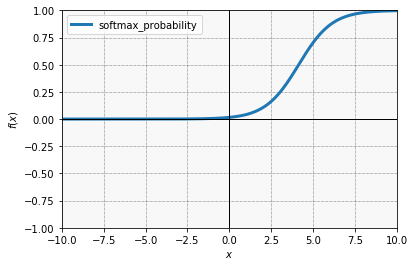

In [15]:
reload(model)

def softmax_probability(x):
    return model.SoftmaxLayer().predict([x]+[-1, 4, 2, 0])[0]
data.graph(softmax_probability, xmin=-10, xmax=+10)

Als de invoer van de softmax-functie twee-dimensionaal is, dat wil zeggen $\boldsymbol{x}=\left[x_1,x_2\right]$, dan heeft het resultaat een nauw verband met de logistische functie. Definieer een nieuwe activatiefunctie `logistic_act_func(a)` die deze logistische functie $\sigma\left(x\right)=\frac{1}{1+e^{-x}}$ berekent.

Hieronder worden beide grafieken in één figuur getoond. Lukt het je om de waarde van de vector $\boldsymbol{v}=\left[-1,4,2,0\right]$ zodanig te veranderen dat deze twee grafieken *exact* samenvallen?

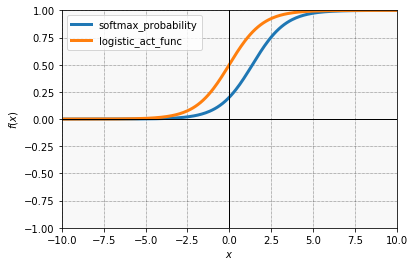

In [21]:
reload(model)

def softmax_probability(x):
    return model.SoftmaxLayer().predict([x]+[0, 0, 0, 0])[0]
data.graph([softmax_probability, model.logistic_act_func], xmin=-10, xmax=+10)

We maken de `SoftmaxLayer()` af. De `loss()` functie is relatief eenvoudig te implementeren. Deze zet de binnenkomende `x` om in een uitvoer (zoals gedaan door de `predict()` functie) en roept met deze uitvoerwaarde de loss-functie van de volgende laag in `self.next` aan. Die retourneert dan uiteindelijk een uitkomst voor de loss, die de `SoftmaxLayer()` terug kan leveren aan de gebruiker.

Schrijf deze functie en test deze met de onderstaande code. Komt de waarde van de loss overeen met een eigen berekening?

In [ ]:
reload(model)

softmax = model.SoftmaxLayer()
softmax.append(model.LossLayer())
x = [-1, 4, 2, 0]
y_hat = softmax.predict(x)
y = [ 0, 1, 0, 0]
l = softmax.loss(x, y)
print('Invoer  =', x)
print('Uitvoer =', y_hat)
print('Labels  =', y)
print('Loss    =', l)

Resteert alleen nog de `train()` functie. Deze dient back-propagation uit te voeren. De gradiënt van de loss naar de uitvoer $\boldsymbol{\nabla_{\hat{y}}}l$ wordt ontvangen van de volgende laag, omgerekend naar de gradiënt van de loss naar de invoer $\boldsymbol{\nabla_{x}}l$, en doorgegeven naar de aanroeper als return value. Net als de `LossLayer()` heeft de `SoftmaxLayer()` geen modelparameters om bij te werken; de learning rate wordt alleen als functieparameter gebruikt om compatibel te zijn met de voorafgaande neurale lagen.

Maak gebruik van de formule

\begin{equation*}
\frac{\partial l}{\partial x_{m}}=\sum_{n}\frac{\partial l}{\partial\hat{y}_{n}}\cdot\frac{\partial\hat{y}_{n}}{\partial x_{m}}=\sum_{n}\frac{\partial l}{\partial\hat{y}_{n}}\cdot\hat{y}_{n}\cdot\left(\delta_{mn}-\hat{y}_{m}\right)
\end{equation*}

om de gradiënt van de loss naar de invoer te berekenen en te retourneren; deze uitdrukking combineert de formules uit de Syllabus. Je krijgt dan iets als dit:

```
def train(self, x, y, alpha=0)
    prediction = ...
    output_gradient = self.next.train(prediction, y, alpha)
    input_gradient = ...
    return input_gradient
```

Tip: de Kronecker-delta $\delta_{mn}$ kun je in Python uitdrukken als `(m == n)`; dit levert een boolean op, maar deze wordt bij berekeningen automatisch gecast naar een waarde gelijk aan 0 (voor `False`) of 1 (voor `True`).

Als je deze code werkend hebt gekregen kun je als het goed is hieronder de eerdere fractale dataset fitten met een model inclusief een softmax laag. Is nu de uitvoer van je model wel te interpreteren als een kans? Dat wil zeggen, zijn de voorspellingen voor alle klassen altijd groter dan nul, en tellen ze op tot één? Komen de fits evengoed redelijk overeen met de verdeling van de datapunten? Oogt de oplossing even goed of zelfs beter dan het vergelijkbare model zonder softmax layer hierboven?

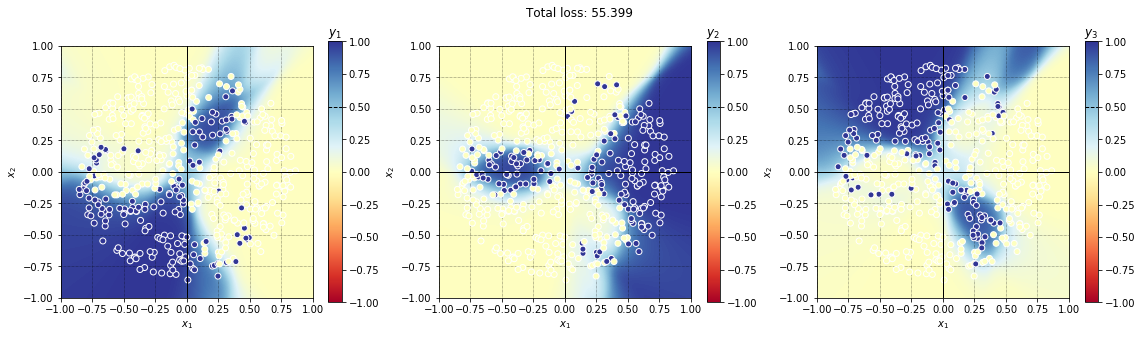

In [22]:
reload(model)

hidden1 = model.FullLayer(2, 10, act_func=model.softsign_act_func)
hidden2 = model.FullLayer(10, 3, act_func=model.identity_act_func)
output = model.SoftmaxLayer()
loss = model.LossLayer(loss_func=model.quadratic_loss_func)
my_network = hidden1 + hidden2 + output + loss
my_network.fit(xs, ys, alpha=0.05)
data.scatter(xs, ys, model=my_network)

## Cross-entropy

De *cross-entropy* loss-functie kan gebruikt worden om de saturatie die op kan treden in de softmax layer tegen te gaan. Het functievoorschrift hiervoor luidt

\begin{equation*}
L\left(\hat{y}_{n};y_{n}\right)=-y_{n}\cdot\ln\left(\hat{y}_{n}\right)-\left(1-y_{n}\right)\cdot\ln\left(1-\hat{y}_{n}\right)
\end{equation*}

We hebben hier gebruik gemaakt van de natuurlijke logaritme $\ln\left(x\right)$. Implementeer de cross-entropy in de vorm van een functie `crossentropy_loss_func(y_hat, y)` en plot de grafiek hieronder. Controleer dat de functie correct werkt voor zowel instances met het werkelijke klasselabel $y_{n}=0$ als voor $y_{n}=1$.

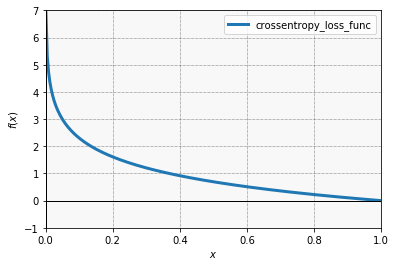

In [23]:
reload(model)

y = 1.0
my_loss_func = model.crossentropy_loss_func
data.graph(my_loss_func, y, xmin=0.001, xmax=0.999)

In de bovenstaande grafiek zijn parameters `xmin=0.001` en `xmax=0.999` meegegeven. Probeer eens uit wat er hoogstwaarschijnlijk misgaat hierboven als je die niet mee zou geven.

Het probleem van de logaritmische functie is dat $\ln\left(x\right)$ alleen maar gedefinieerd is voor $x>0$. De waarde van $\hat{y}_n$ kan in theorie weliswaar nooit helemaal nul worden omdat de softmax-functie altijd een uitkomst tussen nul en één oplevert. Maar in de praktijk kan dit door afronding en underflow wel het geval blijken. Dan gaat het toepassen van de logaritme mis.

Numerieke differentiatie van de loss-functie verergert het probleem nog verder omdat we dan in een kleine omgeving rondom een zekere $x$ moeten kijken, waardoor we zelfs negatieve functie-argumenten kunnen krijgen!

Een workaround kan worden gegeven door een "pseudo-logaritmische" functie te schrijven die nabij $x=0$ een aangepaste uitkomst geeft. Een mogelijkheid is bijvoorbeeld te kiezen voor 

\begin{equation*}
\text{pseudo-ln}\left(x\right)=\left\{ \begin{array}{c}
\ln\left(x\right)\text{ voor }x\geq\epsilon\\
\ln\left(\epsilon\right)+\frac{x-\epsilon}{\epsilon}\text{ voor }x<\epsilon
\end{array}\right.
\end{equation*}

waarbij $\epsilon$ een klein getal is. Hierbij wordt de asymptotische staart van de logaritme vervangen door een steile rechte lijn. De bovenstaande definitie is zo gekozen dat beide stukken functie gladjes op elkaar aansluiten nabij $x=\epsilon$.

Pas je definitie van de cross-entropie aan opdat deze gebruikt maakt van deze "pseudo-logaritme". Verifieer dat de onderstaande code waarin zowel de functie als diens afgeleide wordt getoond zonder foutmeldingen werkt. Speel met de waarde van $\epsilon$ en probeer de vorm van de grafieken te begrijpen.

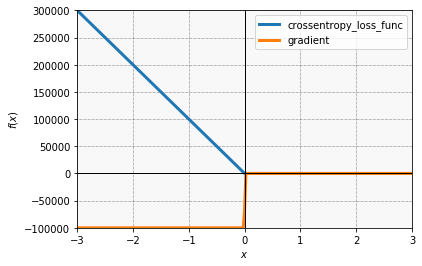

In [25]:
reload(model)

y = 1.0
my_loss_func = model.crossentropy_loss_func
my_loss_grad = model.derivative(my_loss_func)
data.graph([my_loss_func, my_loss_grad], y)

We hebben nu alle ingrediënten om het neurale netwerk van hierboven gebruik te laten maken van de cross-entropy loss-functie. Draai de code hieronder om te testen dat dit naar behoren werkt.

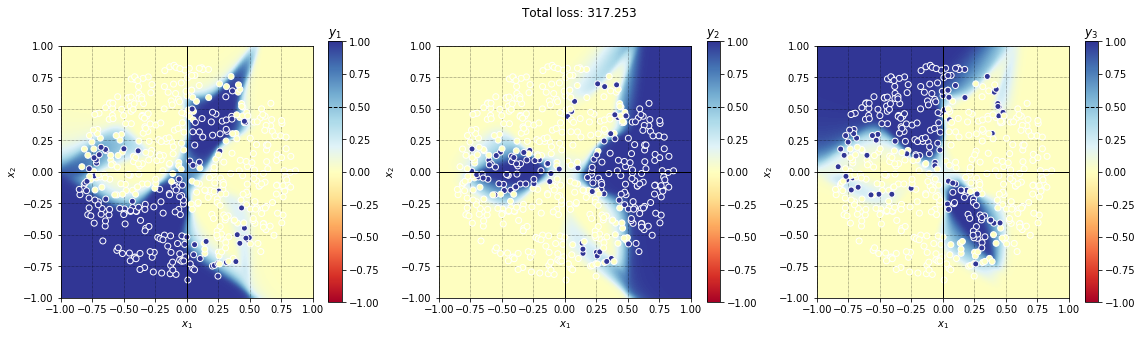

In [26]:
reload(model)

hidden1 = model.FullLayer(2, 10, act_func=model.softsign_act_func)
hidden2 = model.FullLayer(10, 3, act_func=model.identity_act_func)
output = model.SoftmaxLayer()
loss = model.LossLayer(loss_func=model.crossentropy_loss_func)
my_network = hidden1 + hidden2 + output + loss
my_network.fit(xs, ys, alpha=0.05)
data.scatter(xs, ys, model=my_network)

Tenslotte breiden we de verzameling activatiefuncties nog iets verder uit met in elk geval de *softplus* en de *rectified linear unit* functies. Zoek hiervan zelf de definities op. Hieronder worden ze allemaal getoond.

Houd in je functie-definities ook weer rekening met mogelijke under- en overflow; bijvoorbeeld, lukt het je om `logistic_act_func(a)` en `softplus_act_func(a)` correct te evalueren voor $a=\pm1000$?

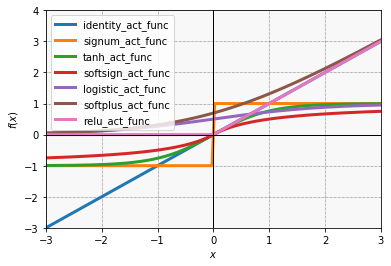

In [27]:
reload(model)

data.graph([model.identity_act_func,
            model.signum_act_func,
            model.tanh_act_func,
            model.softsign_act_func,
            model.logistic_act_func,
            model.softplus_act_func,
            model.relu_act_func])

Hieronder wordt het multinomiale classificatieprobleem opgelost met neurale lagen met een relu-functie, een softmax functie, en een cross-entropy functie. Dit wordt tegenwoordig vaak als uitgangspunt genomen voor classificatie met neurale netwerken. Merk op dat de waarde van de learning rate $\alpha$ is verlaagd om tot een oplossing te convergeren!

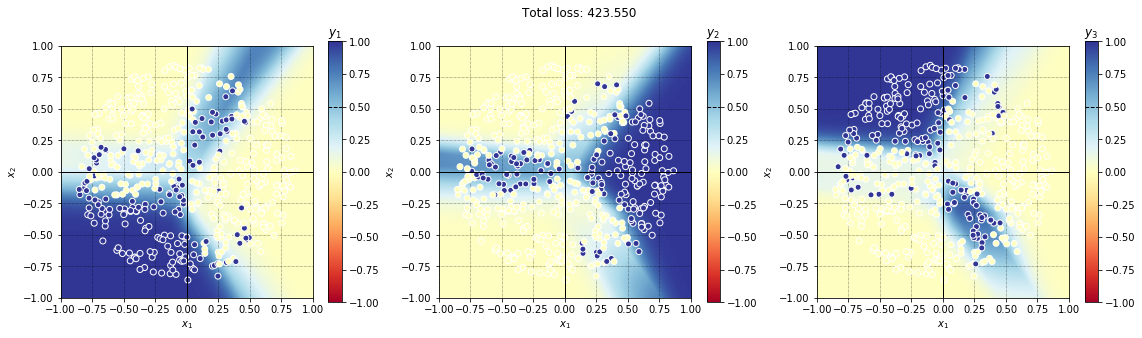

In [28]:
reload(model)

hidden1 = model.FullLayer(2, 10, act_func=model.relu_act_func)
hidden2 = model.FullLayer(10, 3, act_func=model.identity_act_func)
output = model.SoftmaxLayer()
loss = model.LossLayer(loss_func=model.crossentropy_loss_func)
my_network = hidden1 + hidden2 + output + loss
my_network.fit(xs, ys, alpha=0.005)
data.scatter(xs, ys, model=my_network)

**Gefeliciteerd!** Je hebt nu een neuraal netwerk geïmplementeerd dat op een redelijk moderne wijze multinomiale classificatie uitvoert.

Experimenteer weer hoe het algoritme zich gedraagt. Bijvoorbeeld:

- Hoe doen andere activatie-functies het, en wat voor effect heeft dit op de te kiezen learning rate?

- Wat gebeurt er met de vorm van de oplossing als je de hidden layer breder of smaller maakt? Of wat wanneer je een extra hidden layer toevoegt?

- Hoe functioneert het model als je een dataset aanmaakt met meer dan drie verschillende klassen?